<a href="https://www.kaggle.com/code/shellsquareganeshan/handwritten-digit-recognizer-using-cnn?scriptVersionId=187612845" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import classification_report


# Get data

* Each row in the dataset represent an image.
* There are 784 column(28X28=784) in the dataset exculding the class label each representing a pixel with value 0/1.

In [2]:
# read train 
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# read test
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# we have 42000 images in train and 28000 for test
train.shape,test.shape

((42000, 785), (28000, 784))

# Data visualization

* we can visualize the class label inorder to check if the dataset is balanced

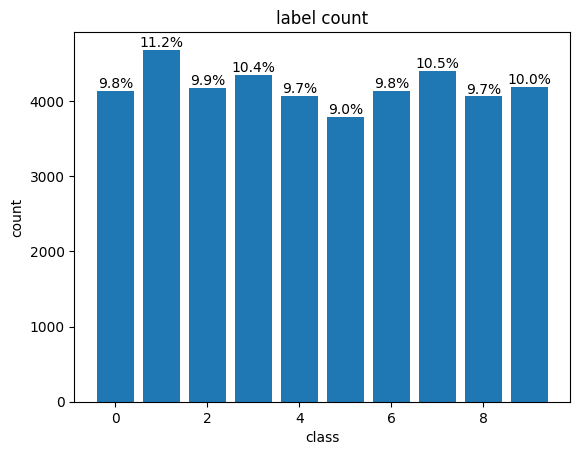

In [5]:
# ploting class label
label_count=train.label.value_counts()
class_perc=label_count/label_count.sum()

plt.bar(label_count.index, label_count.values)
for i in range(len(label_count.index)):
    plt.text(label_count.index[i], label_count.values[i], f'{class_perc[label_count.index[i]]*100:.1f}%', ha='center', va='bottom')

plt.xlabel('class')
plt.ylabel('count')
plt.title('label count')
plt.show()

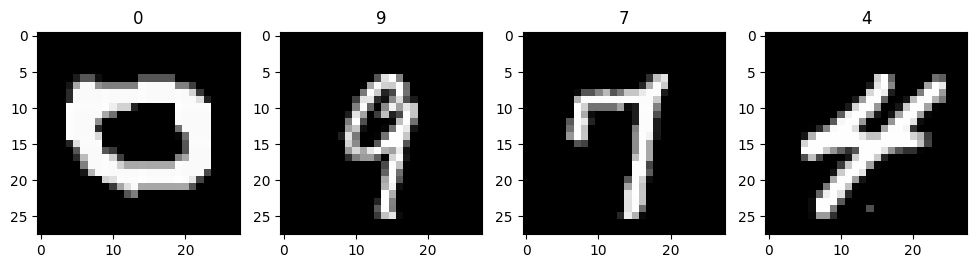

In [6]:
# lets take a look at some of the images at random
plt.figure(figsize=(12,12))
for i in range(1,5): 
    plt.subplot(1,4,i)              
    # plot some random images
    random_image=train.sample(1)
    img=np.reshape(random_image.drop('label',axis=1).values,(28,28))
    plt.imshow(img,cmap='gray')
    plt.title(random_image.label.item())
    # plt.axis("off")
plt.show()

# Splitting data

* we need to convert each rows into a matrix of shape (28,28,1)
* Split the train to X(feature variable) and y(label variable)
* Apply train_test_split on X,y to make a train dataset and a validation dataset.
* Normalize the pixel values of the images

In [7]:
# Adding another dimention to represent color which is 1 because its gray scale (len(train), 28, 28, 1)
X=np.reshape(train.drop('label',axis=1),(len(train),28,28,1))
unique_labels=train.label.unique()
y = train.label
X.shape,y.shape

((42000, 28, 28, 1), (42000,))

In [8]:
X_train,X_val,y_train,y_val=train_test_split(X, y, test_size = 0.2)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((33600, 28, 28, 1), (33600,), (8400, 28, 28, 1), (8400,))

In [9]:
# Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0

# Build model

* Here we create a CNN model which accept input with shape (28,28,1)
* And a dense layer with unit 10 (number of unique classes) at the end.

In [10]:
model_10 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(20, 6, activation='relu',kernel_initializer='he_uniform', input_shape=X_train.shape[1:]),
  tf.keras.layers.Conv2D(20, 3, activation='relu',kernel_initializer='he_uniform'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(20, 3, activation='relu',kernel_initializer='he_uniform'),
  tf.keras.layers.Conv2D(10, 3, activation='relu',kernel_initializer='he_uniform'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu',kernel_initializer='he_uniform'),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [11]:
model_10.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                      patience=6,
                                      mode='max',
                                      restore_best_weights=True)
            
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.2,
                                          patience=3,
                                          mode='max',
                                          min_lr=0.00001)

In [13]:
history= model_10.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val, y_val),callbacks=[callback,reduce])

Epoch 1/20
1050/1050 [==============================] - 26s 23ms/step - loss: 0.3400 - accuracy: 0.8930 - val_loss: 0.1589 - val_accuracy: 0.9513 - lr: 0.0010
Epoch 2/20
1050/1050 [==============================] - 24s 23ms/step - loss: 0.0954 - accuracy: 0.9702 - val_loss: 0.0787 - val_accuracy: 0.9761 - lr: 0.0010
Epoch 3/20
1050/1050 [==============================] - 24s 23ms/step - loss: 0.0685 - accuracy: 0.9786 - val_loss: 0.0708 - val_accuracy: 0.9786 - lr: 0.0010
Epoch 4/20
1050/1050 [==============================] - 24s 23ms/step - loss: 0.0557 - accuracy: 0.9826 - val_loss: 0.0589 - val_accuracy: 0.9826 - lr: 0.0010
Epoch 5/20
1050/1050 [==============================] - 24s 23ms/step - loss: 0.0494 - accuracy: 0.9845 - val_loss: 0.0625 - val_accuracy: 0.9802 - lr: 0.0010
Epoch 6/20
1050/1050 [==============================] - 24s 23ms/step - loss: 0.0386 - accuracy: 0.9886 - val_loss: 0.0676 - val_accuracy: 0.9799 - lr: 0.0010
Epoch 7/20
1050/1050 [========================

# Model evaluation

<Axes: >

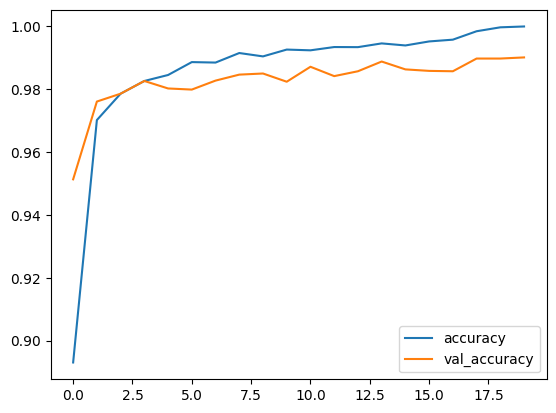

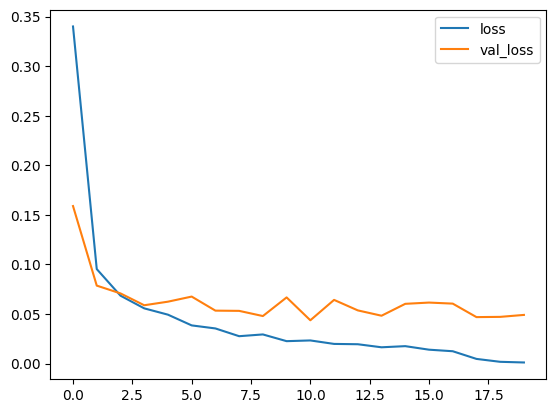

In [14]:
# Accuracy and loss graph between train and validation dataset.
evaluation=pd.DataFrame(model_10.history.history)
evaluation[['accuracy','val_accuracy']].plot()
evaluation[['loss','val_loss']].plot()

In [15]:
# Confusion matrix
y_val_pred = tf.math.argmax(model_10.predict(X_val), 1).numpy()
display(pd.crosstab(y_val, y_val_pred, rownames=['True'], colnames=['Predicted'], margins=True))

263/263 [==============================] - 2s 7ms/step


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,800,0,0,0,0,0,0,0,2,1,803
1,1,913,1,0,1,1,0,1,0,0,918
2,0,2,805,1,2,0,0,3,2,0,815
3,0,0,3,886,0,5,0,0,2,1,897
4,0,2,0,0,781,0,2,0,1,5,791
5,1,0,0,3,0,769,1,0,2,2,778
6,0,0,1,0,0,1,786,0,1,0,789
7,0,2,4,1,1,0,0,893,0,0,901
8,1,0,1,0,0,2,0,1,850,5,860


In [16]:
# Classification report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       803
           1       0.99      0.99      0.99       918
           2       0.99      0.99      0.99       815
           3       0.99      0.99      0.99       897
           4       0.99      0.99      0.99       791
           5       0.98      0.99      0.99       778
           6       1.00      1.00      1.00       789
           7       0.99      0.99      0.99       901
           8       0.99      0.99      0.99       860
           9       0.98      0.98      0.98       848

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



* Make prediction for test data

In [17]:
X_test=np.reshape(test,(len(test),28,28,1))
X_test=X_test/255
y_pred = tf.math.argmax(model_10.predict(X_test), 1).numpy()
test['label']=y_pred

875/875 [==============================] - 6s 7ms/step


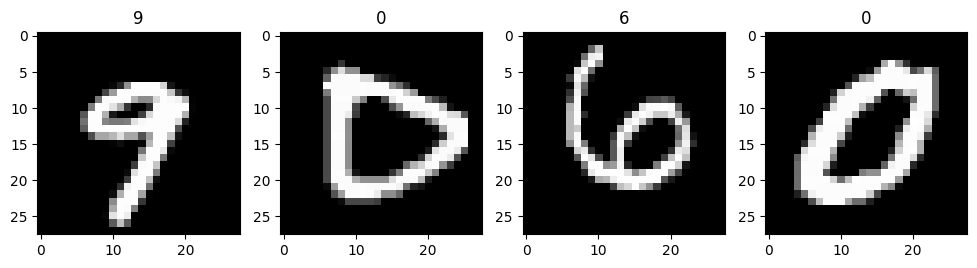

In [18]:
# lets take a look at some of the images at random from the test dataset
plt.figure(figsize=(12,12))
for i in range(1,5): 
    plt.subplot(1,4,i)              
    # plot some random images
    random_image=test.sample(1)
    img=np.reshape(random_image.drop('label',axis=1).values,(28,28))
    plt.imshow(img,cmap='gray')
    plt.title(random_image.label.item())
    # plt.axis("off")
plt.show()

# Submit result

In [19]:
test['ImageId'] = range(1, len(test) + 1)
test[['ImageId','label']].to_csv('submission.csv', index=False)